# 

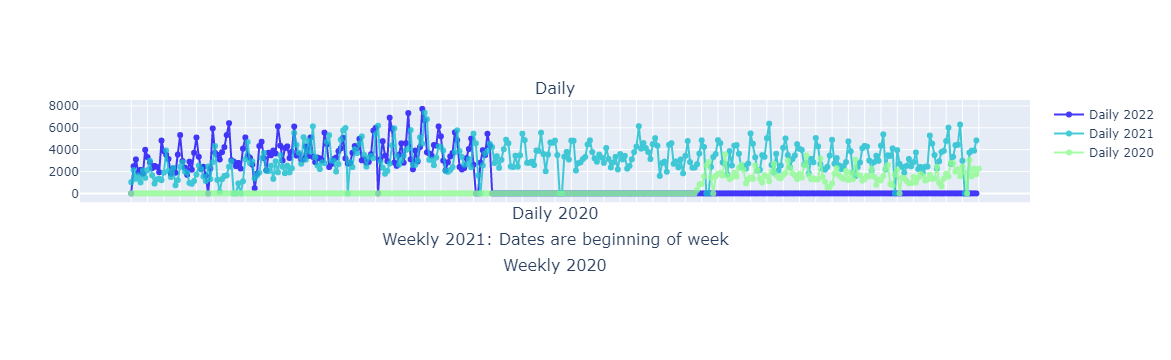

In [30]:
"""
	This file contains most of the constant global variables that can be accessed
	with other programs.
"""

import pandas as pd
import calendar


'''
    After importing and skewing unwanted data,
    rows are dailies
    columns are date, subtotal, ticket discount, and gift sale
'''

# hardcoded file paths for each year summary
files = []
files.append("totalSalesSummary2020.xlsx")
files.append("totalSalesSummary2021.xlsx")
files.append("totalSalesSummary2022.xlsx")

# table is an array of an arrray; 
# yearly array of dates ranging from 1/1/2020 - 1/1/2030
table = []

for i in range(2020,2031):
    start = "1/1/" + str(i)
    end = "12/31/" + str(i)
    t = pd.date_range(start=start, end=end)
    table.append(t)

# this table is used for sharing data from multiple years
# xtable is days of the leap year without actual year. 
# used during plotting to plot multiple years
xDailyTable = []

oddMonths = ["January", "March", "May", "July", "August", "October", "December"]
evenMonths = ["April", "June", "September", "November"]

for month in calendar.month_name[1:]:
    if month in oddMonths:
        for days in range(1,32):
            xDailyTable.append(month + " " + str(days))
    elif month in evenMonths:
        for days in range(1,31):
            xDailyTable.append(month + " " + str(days))
    else:
        for days in range(1,30):
            xDailyTable.append(month + " " + str(days))
            
            
            
#===========================================================================================================================================================
import pandas as pd
import datetime
import calendar
import copy
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import plotly
from plotly.offline import init_notebook_mode

init_notebook_mode(connected = True)


def createDf(files):
    """
    takes an array of yearly income and converts from daily to weekly with
    Monday as the starting week

    Parameters
    ----------
    files : array of file locations 
        Each year has its own excel file for daily income      

    Returns
    -------
    df : array of dataframes
        dataframes are divided yearly. Each year has a daily income represented
        by month and day in the first column and income amount in the second
        column. (year is removed from date in order to share the x-axis 
        while plotting) 

    """
    # declare empty for yearly dataframes
    df = []    
    
    for path in files:    
        # retrieves dataframe using pandas
        dfIncome = pd.read_excel(path, sheet_name=0)
        # deletes unwanted header rows and replace is set to true
        dfIncome.drop(
            labels=[0,1],
            axis=0,
            inplace=True
        )
        # deletes unwanted columns (use iloc if column names have duplicates)
        dfIncome.drop(
            columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4","Unnamed: 5", "Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 9"],
            inplace=True
        )
        # removes header rows that are not actual column labels and also 
        newHeader = dfIncome.iloc[0]
        # removes last row labeled grand total
        dfIncome = dfIncome[1:len(dfIncome)-1]
        dfIncome.columns = newHeader
        #At this point, dfIncome dataframe has two columns, Date and Subtotal
        
        # format data into full years, 2020 was midyear
        year = dfIncome.iloc[0][0].year % 2020
                       
# =============================================================================
#         # test timestamp manipulation
#         print(type(dfIncome.iloc[0][0]))
#         print(dfIncome.iloc[0][0].month,dfIncome.iloc[0][0].day)
#         print(calendar.isleap(dfIncome.iloc[0][0].year))
#         print(dfIncome.iloc[0][0].timetuple().tm_yday)
# =============================================================================
         # create table with dates from jan 1 w/ correlating income
        day = dfIncome.iloc[0][0].timetuple().tm_yday -1
        
        formattedDf = pd.DataFrame(columns=["Date", "Sub Total"])
        dates = table[year]
        j = 0
        for i in range(len(dates) - 1):
            # dates are only used for comparison with given data, 
            # but once formated, we use xDailyTable dates to remove year differences
            # in order to share same x-axis between different years            
            try:
                # try and except for when current year has not past and dfIncome 
                # has run out of data. when that happens, income is filled with 0
                incomeDate = dfIncome.iloc[j][0].date()
                
                if dates[i].date() < dfIncome.iloc[j][0].date():
                    # year 2020 started in september, therefore dfIncome's date
                    # started midyear. To fix this, we add income of 0 for each
                    # missing date, this includes any holiday closures
                    rowDf = pd.DataFrame([[xDailyTable[i], 0]], columns=["Date", "Sub Total"])
                    formattedDf = pd.concat([formattedDf,rowDf], ignore_index=True)
                else:
                    rowDf = pd.DataFrame([[xDailyTable[i], dfIncome.iloc[j][1]]],columns=["Date", "Sub Total"])
                    formattedDf = pd.concat([formattedDf,rowDf], ignore_index=True)
                    j = j + 1
            except IndexError:
                rowDf = pd.DataFrame([[xDailyTable[i], 0]], columns=["Date", "Sub Total"])
                formattedDf = pd.concat([formattedDf,rowDf], ignore_index=True)
           
        df.append(formattedDf)
        
    return df


def convertWeekly(df):
    """
    takes an array of yearly income and converts from daily to weekly with
    Monday as the starting week

    Parameters
    ----------
    df : array of dataframes
        each dataframe contains total daily sales.
        columns are ["Date","Subtotal","Ticket Discount","Gift Sale"]

    Returns
    -------
    weekly : array of dataframes
        Sum of weekly income starting on Mondays

    """
    weekly = []
    
    for data in df:
        # using the daily dataframe, this resamples the the whole data into weekly totals with "Date" as the
        # index. Sum calculated from monday - sunday and sunday will be used as label
        weeklyIncome = data.set_index("Date", inplace=False).resample("W-SUN", label="right", closed="right").sum()
        # reset index so we can use it as a y axis for graphing
        weeklyIncome.reset_index(inplace=True)
        weekly.append(weeklyIncome)
    
    return weekly

            
def graph(df):
    #weeklyDf = convertWeekly(df)
    
    # create figure
    fig = make_subplots(rows=4, 
                        cols=1, 
                        shared_xaxes=True,
                        subplot_titles=("Daily", "Daily 2020",
                                        "Weekly 2021: Dates are beginning of week",
                                        "Weekly 2020"),
                        row_heights=[30,1,1,1]
    )
    
    # add traces
    colors = ["#17BECF","#90fc92","#1809f8"]
    fig.append_trace(
        go.Scatter(
            x=df[2]["Date"].tolist(),
            y=df[2]["Sub Total"].tolist(),
            name="Daily 2022",
            line=dict(color=colors[2]),
            opacity=0.8
            ),
        row=1,
        col=1
    )
    
    fig.append_trace(
        go.Scatter(
            x=df[1]["Date"].tolist(),
            y=df[1]["Sub Total"].tolist(),
            name="Daily 2021",
            line= dict(color=colors[0]),
            opacity=0.8
            ),
        row=1,
        col=1
    )
    
    fig.append_trace(
        go.Scatter(
            x=df[0]["Date"].tolist(),
            y=df[0]["Sub Total"].tolist(),
            name="Daily 2020",
            line= dict(color=colors[1]),
            opacity=0.8
            ),
        row=1,
        col=1
    )    
    
# =============================================================================
#     fig.append_trace(
#         go.Scatter(
#             x=weeklyDf[1]["Date"].tolist(),
#             y=weeklyDf[1]["Sub Total"].tolist(),
#             name="Weekly 2021",
#             line= dict(color=colors[0]),
#             opacity=0.8
#             ),
#         
#         row=3,
#         col=1
#     )
#     
#     fig.append_trace(
#         go.Scatter(
#             x=weeklyDf[0]["Date"].tolist(),
#             y=weeklyDf[0]["Sub Total"].tolist(),
#             name="Weekly 2020",
#             line= dict(color=colors[1]),
#             opacity=0.8
#             ),
#         row=4,
#         col=1
#     ) 
# =============================================================================
    
    # style all traces
    fig.update_traces(
        hoverinfo="x+y",
        mode="lines+markers"
    )
    
    # new plotly update removed "compare data on hover" so manually update to it adds it back in plot
    fig.update_layout(
        modebar_add=["v1hovermode","toggleSpikelines"],
        modebar_remove=['zoom', 'pan']
    )
    
    pio.write_html(fig, file="upscale.html", auto_open=True)
    
    plotly.offline.iplot({ "data": fig,"layout": go.Layout(title="daily")})
        
        
#============================================================================================================================================

df = createDf(files)

graph(df)
